# Lesson 5 - Gradient Boosting with XGBoost

In [1]:
!pip install numpy pandas matplotlib seaborn --quiet


In [2]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

In [3]:
import os 
import opendatasets as od
import pandas as pd
pd.set_option("Display.max_columns",120)
pd.set_option("Display.max_rows",120)

In [4]:
ross_df=pd.read_csv('train.csv',low_memory=False)
store_df=pd.read_csv('store.csv')
test_df=pd.read_csv('test.csv')
submission_df=pd.read_csv('sample_submission.csv')

In [5]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [6]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [7]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [8]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [9]:
merged_df=ross_df.merge(store_df,how='left',on='Store')
merged_test_df=test_df.merge(store_df,how='left',on='Store')

In [10]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [11]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "m-zakirhossen99/lesson4" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/m-zakirhossen99/lesson4


'https://jovian.com/m-zakirhossen99/lesson4'

In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

## Date(First,let's convert Date to datetime column and extract different parts of the date.)  

In [13]:
def split_date(df):
    df['Date']=pd.to_datetime(df['Date'])
    df['Year']=df.Date.dt.year
    df['Month']=df.Date.dt.month
    df['Day']=df.Date.dt.day
    df['WeekOfYear']=df.Date.dt.isocalendar().week
    

In [14]:
split_date(merged_df)
split_date(merged_test_df)

In [15]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


## Store Open/Closed

#### Next, Notice that the sales are zero whenever the store is closed

In [16]:
merged_df[merged_df.Open==0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

####  Instead of trying to model this relationship,it would be better to hard-code it in out predictions,and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [17]:
merged_df=merged_df[merged_df.Open==1].copy()

### Competition


######  Newt,we can use the columns CompetitionOpenSince[Month/Year] columns from store_df to compute the number of months for which a competitor has been open near the store.

In [18]:
def comp_months(df):
    df['CompetitionOpen']=12*(df.Year-df.CompetitionOpenSinceYear)+(df.Month-df.CompetitionOpenSinceMonth)
    df['CompetitionOpen']=df['CompetitionOpen'].map(lambda x:0 if x<0 else x).fillna(0)

In [19]:
comp_months(merged_df)
comp_months(merged_test_df)

In [20]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


In [21]:
merged_df[['Date','CompetitionDistance','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
81261,2015-05-20,21930.0,NaN,NaN,0.0
505728,2014-04-04,1950.0,2015.0,7.0,0.0
81660,2015-05-19,360.0,2014.0,3.0,14.0
394664,2014-07-15,1390.0,2004.0,12.0,115.0
160761,2015-03-09,5140.0,2010.0,5.0,58.0
343380,2014-09-08,2180.0,2012.0,9.0,24.0
427470,2014-06-13,8780.0,2005.0,2.0,112.0
702875,2013-10-09,8780.0,2005.0,2.0,104.0
510285,2014-03-31,9200.0,2009.0,10.0,53.0
968403,2013-02-13,330.0,2008.0,3.0,59.0


## Additional Promotion

######  We can also add some additional columns to indicate how long a store has been running promo2 and whether a new round of Promo2 starts in the current month

In [22]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    # Whether a new round of promotions was started in the current month
    df['Promo2Open']=df['Promo2Open'].clip(lower=0)
    df['Promo2Open']=df['Promo2Open']*df['Promo2']
    #df['Promo2Open'] = df['Promo2Open'].map(lambda x:0 if x < 0 else x).fillna(0) * df['Promo2']
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [23]:
promo_cols(merged_df)

In [24]:
promo_cols(merged_test_df)

In [25]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
788660,2013-07-24,0,NaN,NaN,NaN,<NA>,0
757516,2013-08-21,1,2014.0,10.0,"Mar,Jun,Sept,Dec",0.0,0
97211,2015-05-05,0,NaN,NaN,NaN,<NA>,0
593095,2014-01-16,1,2011.0,14.0,"Jan,Apr,Jul,Oct",33.47541,1
494332,2014-04-14,1,2012.0,27.0,"Jan,Apr,Jul,Oct",21.47541,1
274839,2014-11-20,1,2011.0,18.0,"Feb,May,Aug,Nov",42.655738,1
268299,2014-11-27,0,NaN,NaN,NaN,<NA>,0
19195,2015-07-14,0,NaN,NaN,NaN,<NA>,0
150192,2015-03-19,0,NaN,NaN,NaN,<NA>,0
248972,2014-12-18,0,NaN,NaN,NaN,<NA>,0


In [26]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "m-zakirhossen99/lesson4" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/m-zakirhossen99/lesson4


'https://jovian.com/m-zakirhossen99/lesson4'

###  Input and Target Columns

In [27]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [28]:
input_cols=['Store','DayOfWeek','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment','CompetitionDistance','CompetitionOpen','Day','Month','Year','WeekOfYear','Promo2','Promo2Open','IsPromo2Month']
target_cols='Sales'

In [29]:
inputs=merged_df[input_cols].copy()
targets=merged_df[target_cols].copy()

In [30]:
test_input=merged_test_df[input_cols].copy()

In [31]:
numeric_cols=['Store','Promo','SchoolHoliday','CompetitionDistance',
              'CompetitionOpen','Promo2','Promo2Open','IsPromo2Month',
              'Day','Month','Year','WeekOfYear']
categorical_cols=['DayOfWeek','StateHoliday','StoreType','Assortment']

In [32]:
inputs[numeric_cols].isna().sum()

Store                       0
Promo                       0
SchoolHoliday               0
CompetitionDistance      2186
CompetitionOpen             0
Promo2                      0
Promo2Open             423307
IsPromo2Month               0
Day                         0
Month                       0
Year                        0
WeekOfYear                  0
dtype: int64

In [33]:
test_input[numeric_cols].isna().sum()

Store                      0
Promo                      0
SchoolHoliday              0
CompetitionDistance       96
CompetitionOpen            0
Promo2                     0
Promo2Open             17232
IsPromo2Month              0
Day                        0
Month                      0
Year                       0
WeekOfYear                 0
dtype: int64

######  Seems like competition distance is the only missiing value,and we can simply fill it with the highgest value(to indicate that competition is very far away)

In [34]:
max_distance=inputs.CompetitionDistance.max()

In [35]:
#inputs['CompetitionDistance'].fillna(max_distance,inplace=True)
test_input['CompetitionDistance'].fillna(max_distance,inplace=True)
#inputs.fillna({'CompetitionDistance':max_distance},inplace=True)
inputs['CompetitionDistance']=inputs['CompetitionDistance'].fillna(max_distance)

In [36]:
inputs[numeric_cols].isna().sum()

Store                       0
Promo                       0
SchoolHoliday               0
CompetitionDistance         0
CompetitionOpen             0
Promo2                      0
Promo2Open             423307
IsPromo2Month               0
Day                         0
Month                       0
Year                        0
WeekOfYear                  0
dtype: int64

In [37]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "m-zakirhossen99/lesson4" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/m-zakirhossen99/lesson4


'https://jovian.com/m-zakirhossen99/lesson4'

###  Scale Numberic Values

In [38]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
scaler=MinMaxScaler().fit(inputs[numeric_cols])

In [40]:
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,<NA>,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,64.131148,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,51.901639,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,<NA>,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,0,a,1,b,a,150.0,76.0,1,1,2013,1,0,<NA>,0
1016827,733,2,0,a,1,b,b,860.0,159.0,1,1,2013,1,0,<NA>,0
1016863,769,2,0,a,1,b,b,840.0,0.0,1,1,2013,1,1,1.213115,1
1017042,948,2,0,a,1,b,b,1430.0,0.0,1,1,2013,1,0,<NA>,0


In [41]:
inputs[numeric_cols]=scaler.transform(inputs[numeric_cols])

In [42]:
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,0.000000,5,1.0,0,1.0,c,a,0.016482,0.059163,1.0,0.545455,1.0,0.588235,0.0,NaN,0.0
1,0.000898,5,1.0,0,1.0,a,a,0.007252,0.066378,1.0,0.545455,1.0,0.588235,1.0,0.890710,1.0
2,0.001795,5,1.0,0,1.0,a,a,0.186050,0.074315,1.0,0.545455,1.0,0.588235,1.0,0.720856,1.0
3,0.002693,5,1.0,0,1.0,c,c,0.007911,0.050505,1.0,0.545455,1.0,0.588235,0.0,NaN,0.0
4,0.003591,5,1.0,0,1.0,a,a,0.394119,0.002165,1.0,0.545455,1.0,0.588235,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.611311,2,0.0,a,1.0,b,a,0.001714,0.054834,0.0,0.000000,0.0,0.000000,0.0,NaN,0.0
1016827,0.657092,2,0.0,a,1.0,b,b,0.011076,0.114719,0.0,0.000000,0.0,0.000000,0.0,NaN,0.0
1016863,0.689408,2,0.0,a,1.0,b,b,0.010812,0.000000,0.0,0.000000,0.0,0.000000,1.0,0.016849,1.0
1017042,0.850090,2,0.0,a,1.0,b,b,0.018592,0.000000,0.0,0.000000,0.0,0.000000,0.0,NaN,0.0


## Encode Categorical Columns

In [43]:
from sklearn.preprocessing import OneHotEncoder

In [44]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


In [45]:
encoder=OneHotEncoder(sparse_output=False,handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols=list(encoder.get_feature_names_out(categorical_cols))

In [46]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_input[encoded_cols] = encoder.transform(test_input[categorical_cols])

In [47]:
x=inputs[numeric_cols+encoded_cols]
x_test=test_input[numeric_cols+encoded_cols]

In [48]:
jovian.commit()


<IPython.core.display.Javascript object>

[jovian] Updating notebook "m-zakirhossen99/lesson4" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/m-zakirhossen99/lesson4


'https://jovian.com/m-zakirhossen99/lesson4'

# Gradient Boosting

In [49]:
from xgboost import XGBRegressor

In [50]:
?XGBRegressor

In [51]:
model=XGBRegressor(random_state=42,n_jobs=-1,n_estimators=20,max_depth=4)

In [52]:
%%time
model.fit(x,targets)

CPU times: total: 40.8 s
Wall time: 7.3 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

## Prediction

In [53]:
preds=model.predict(x)

In [54]:
preds

array([ 7915.224,  8167.21 ,  8493.566, ...,  7854.969,  8145.592,
       10950.482], dtype=float32)

### Evaluation

In [55]:
from sklearn.metrics import mean_squared_error
def rmse(a,b):
    return mean_squared_error(a,b,squared=False)

In [56]:
rmse(preds,targets)

C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2399.87310400076

###  Visualization

In [57]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 100,80

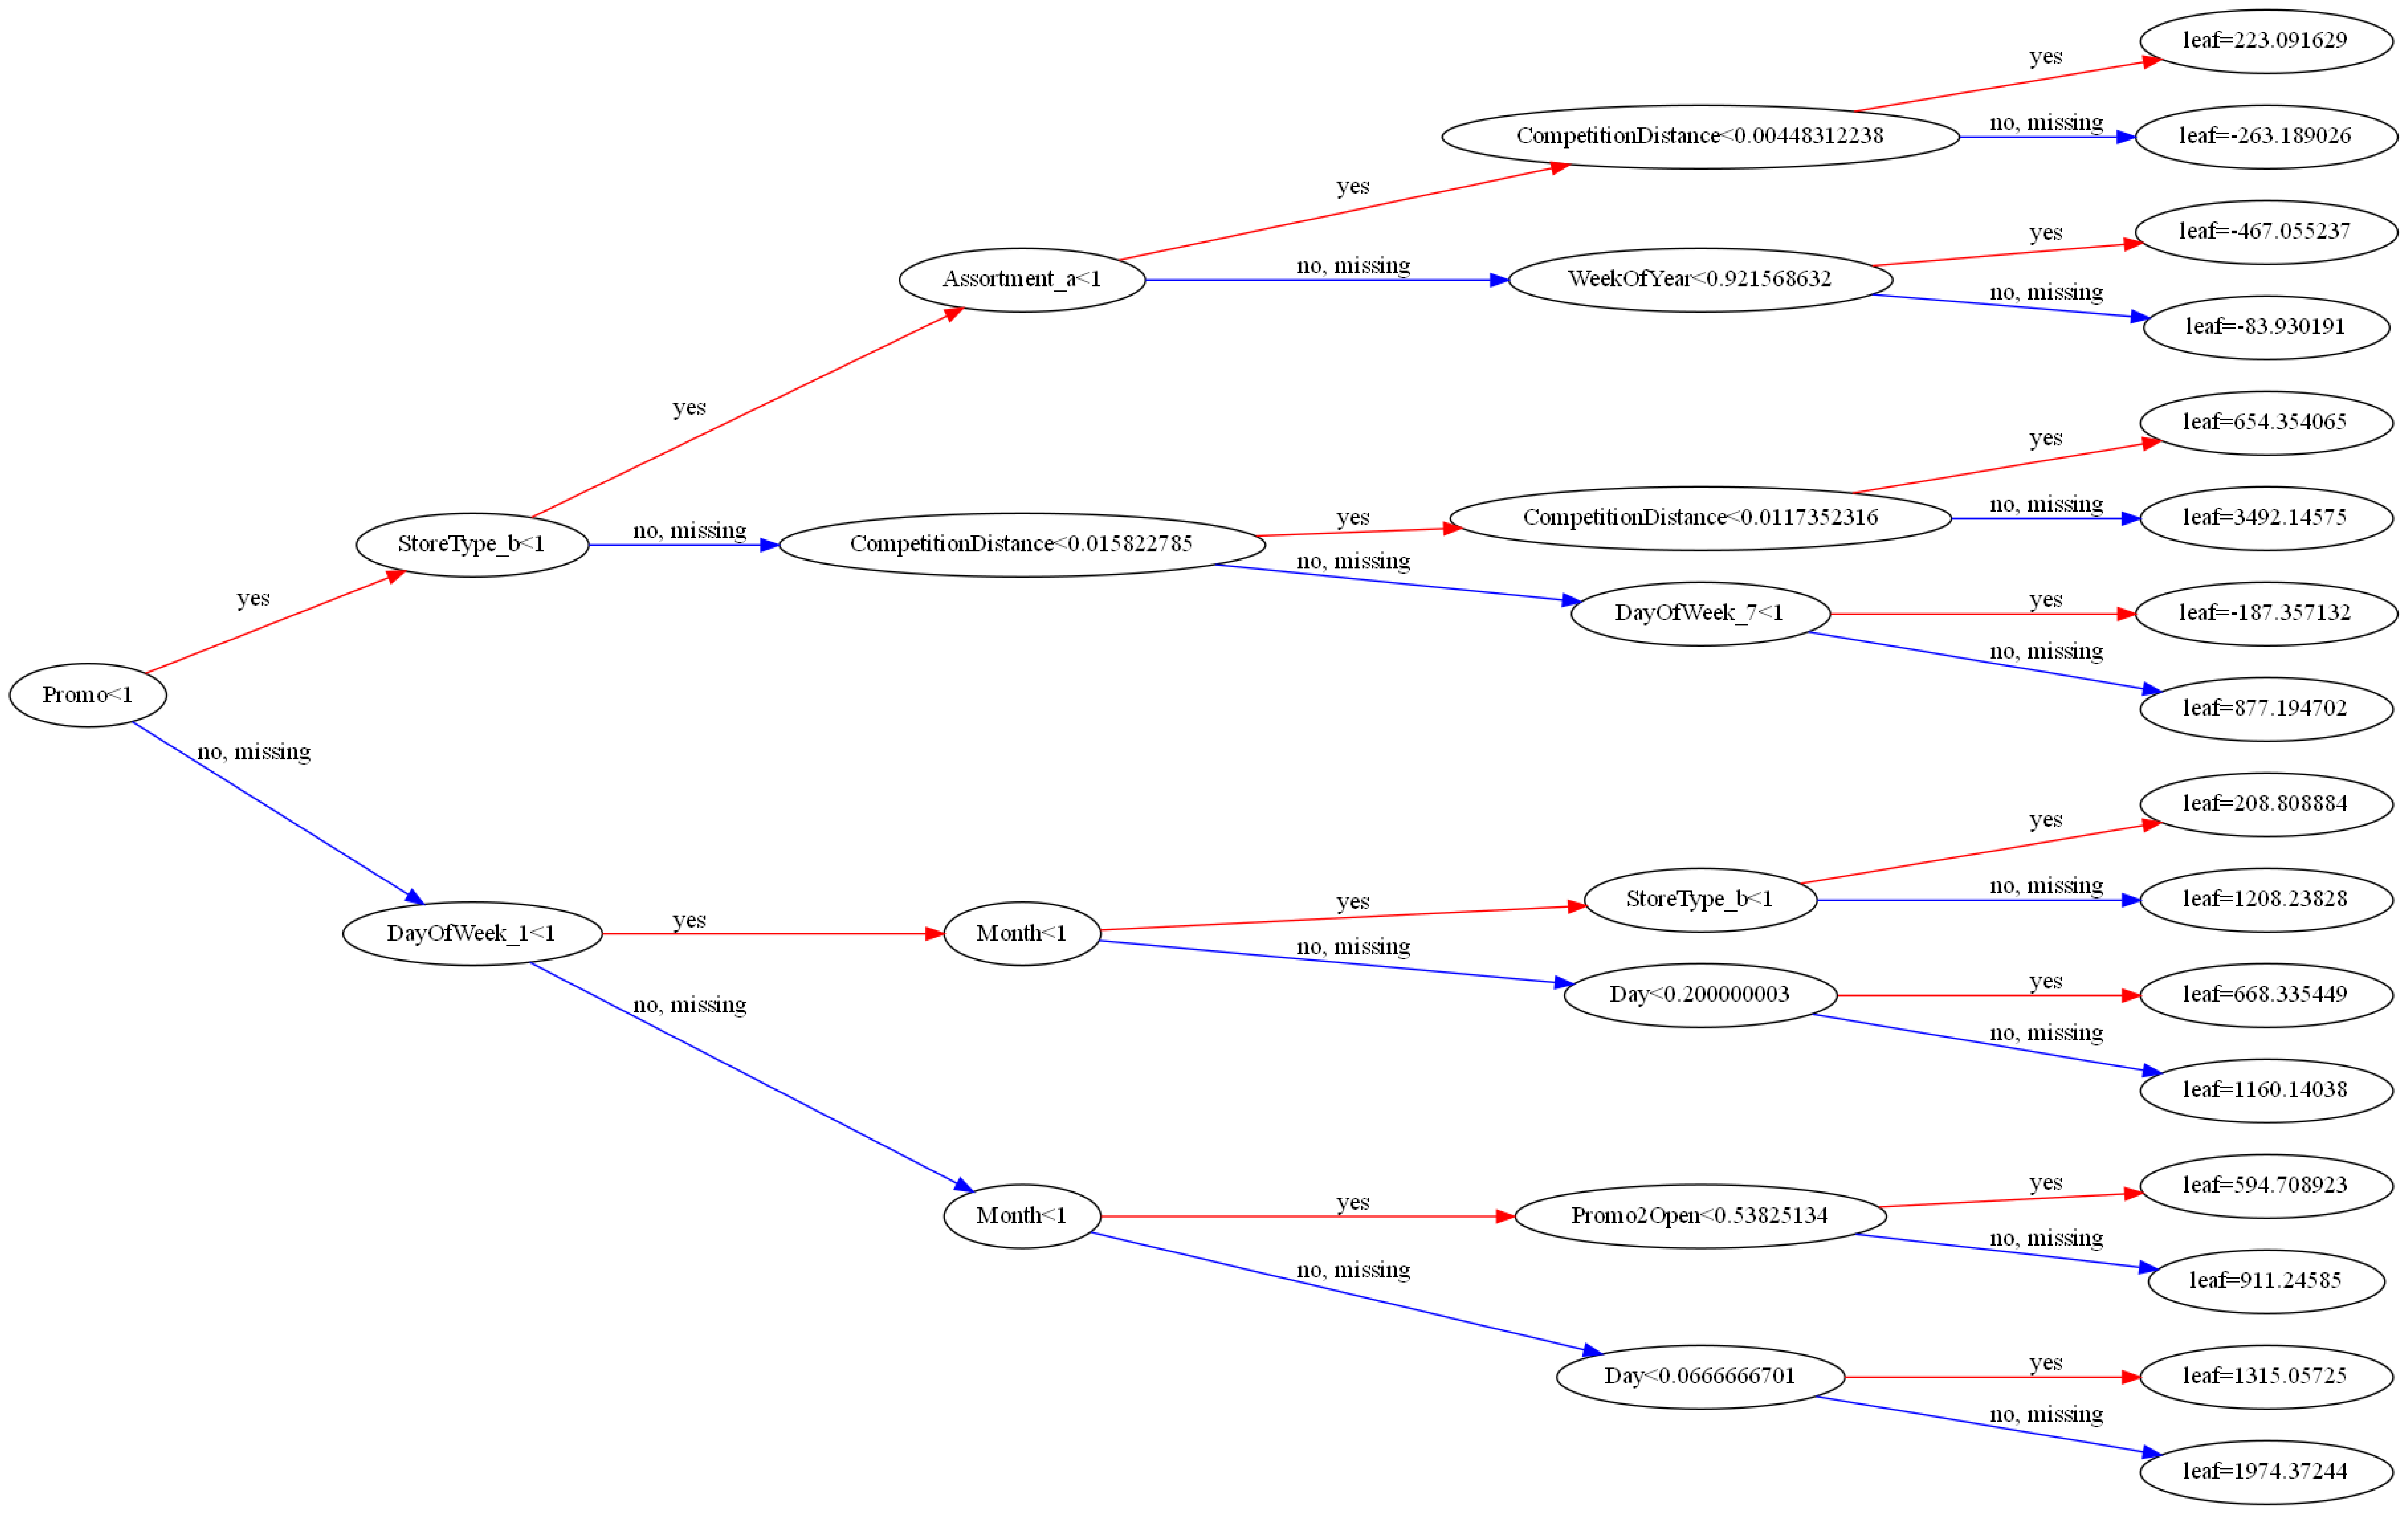

In [58]:
plot_tree(model, rankdir='LR');

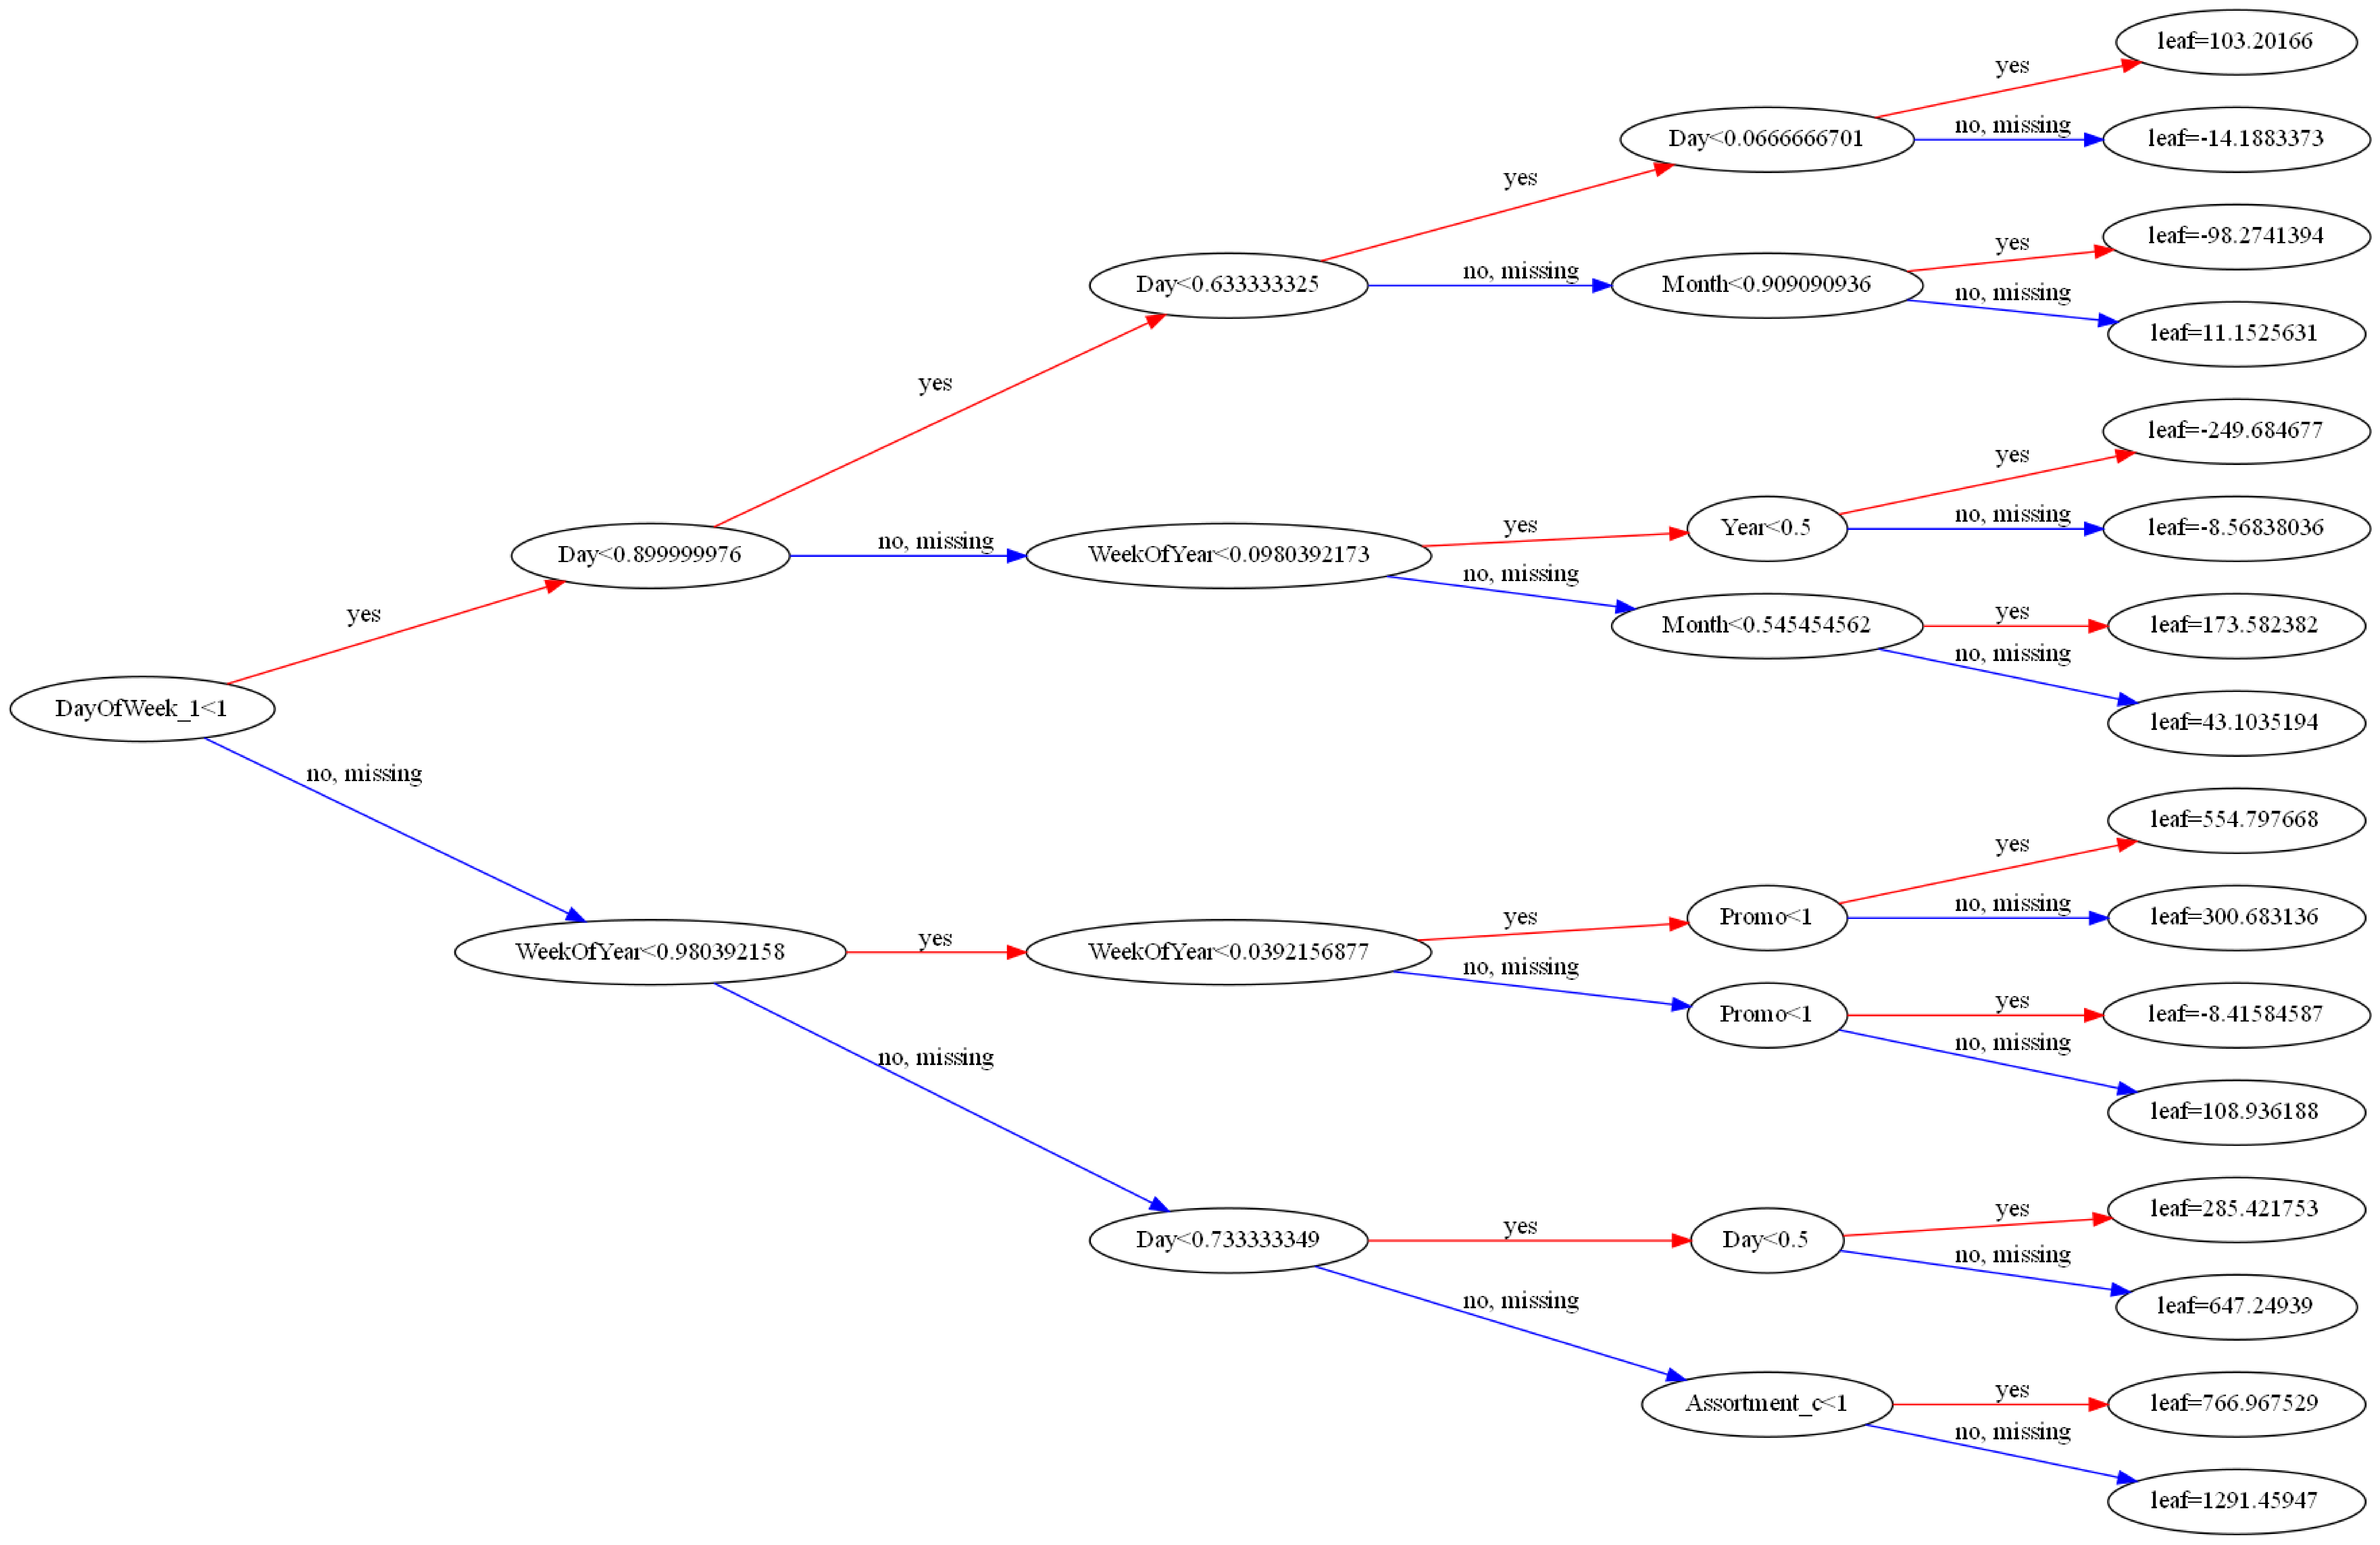

In [59]:
plot_tree(model,rankdir='LR',num_trees=10);

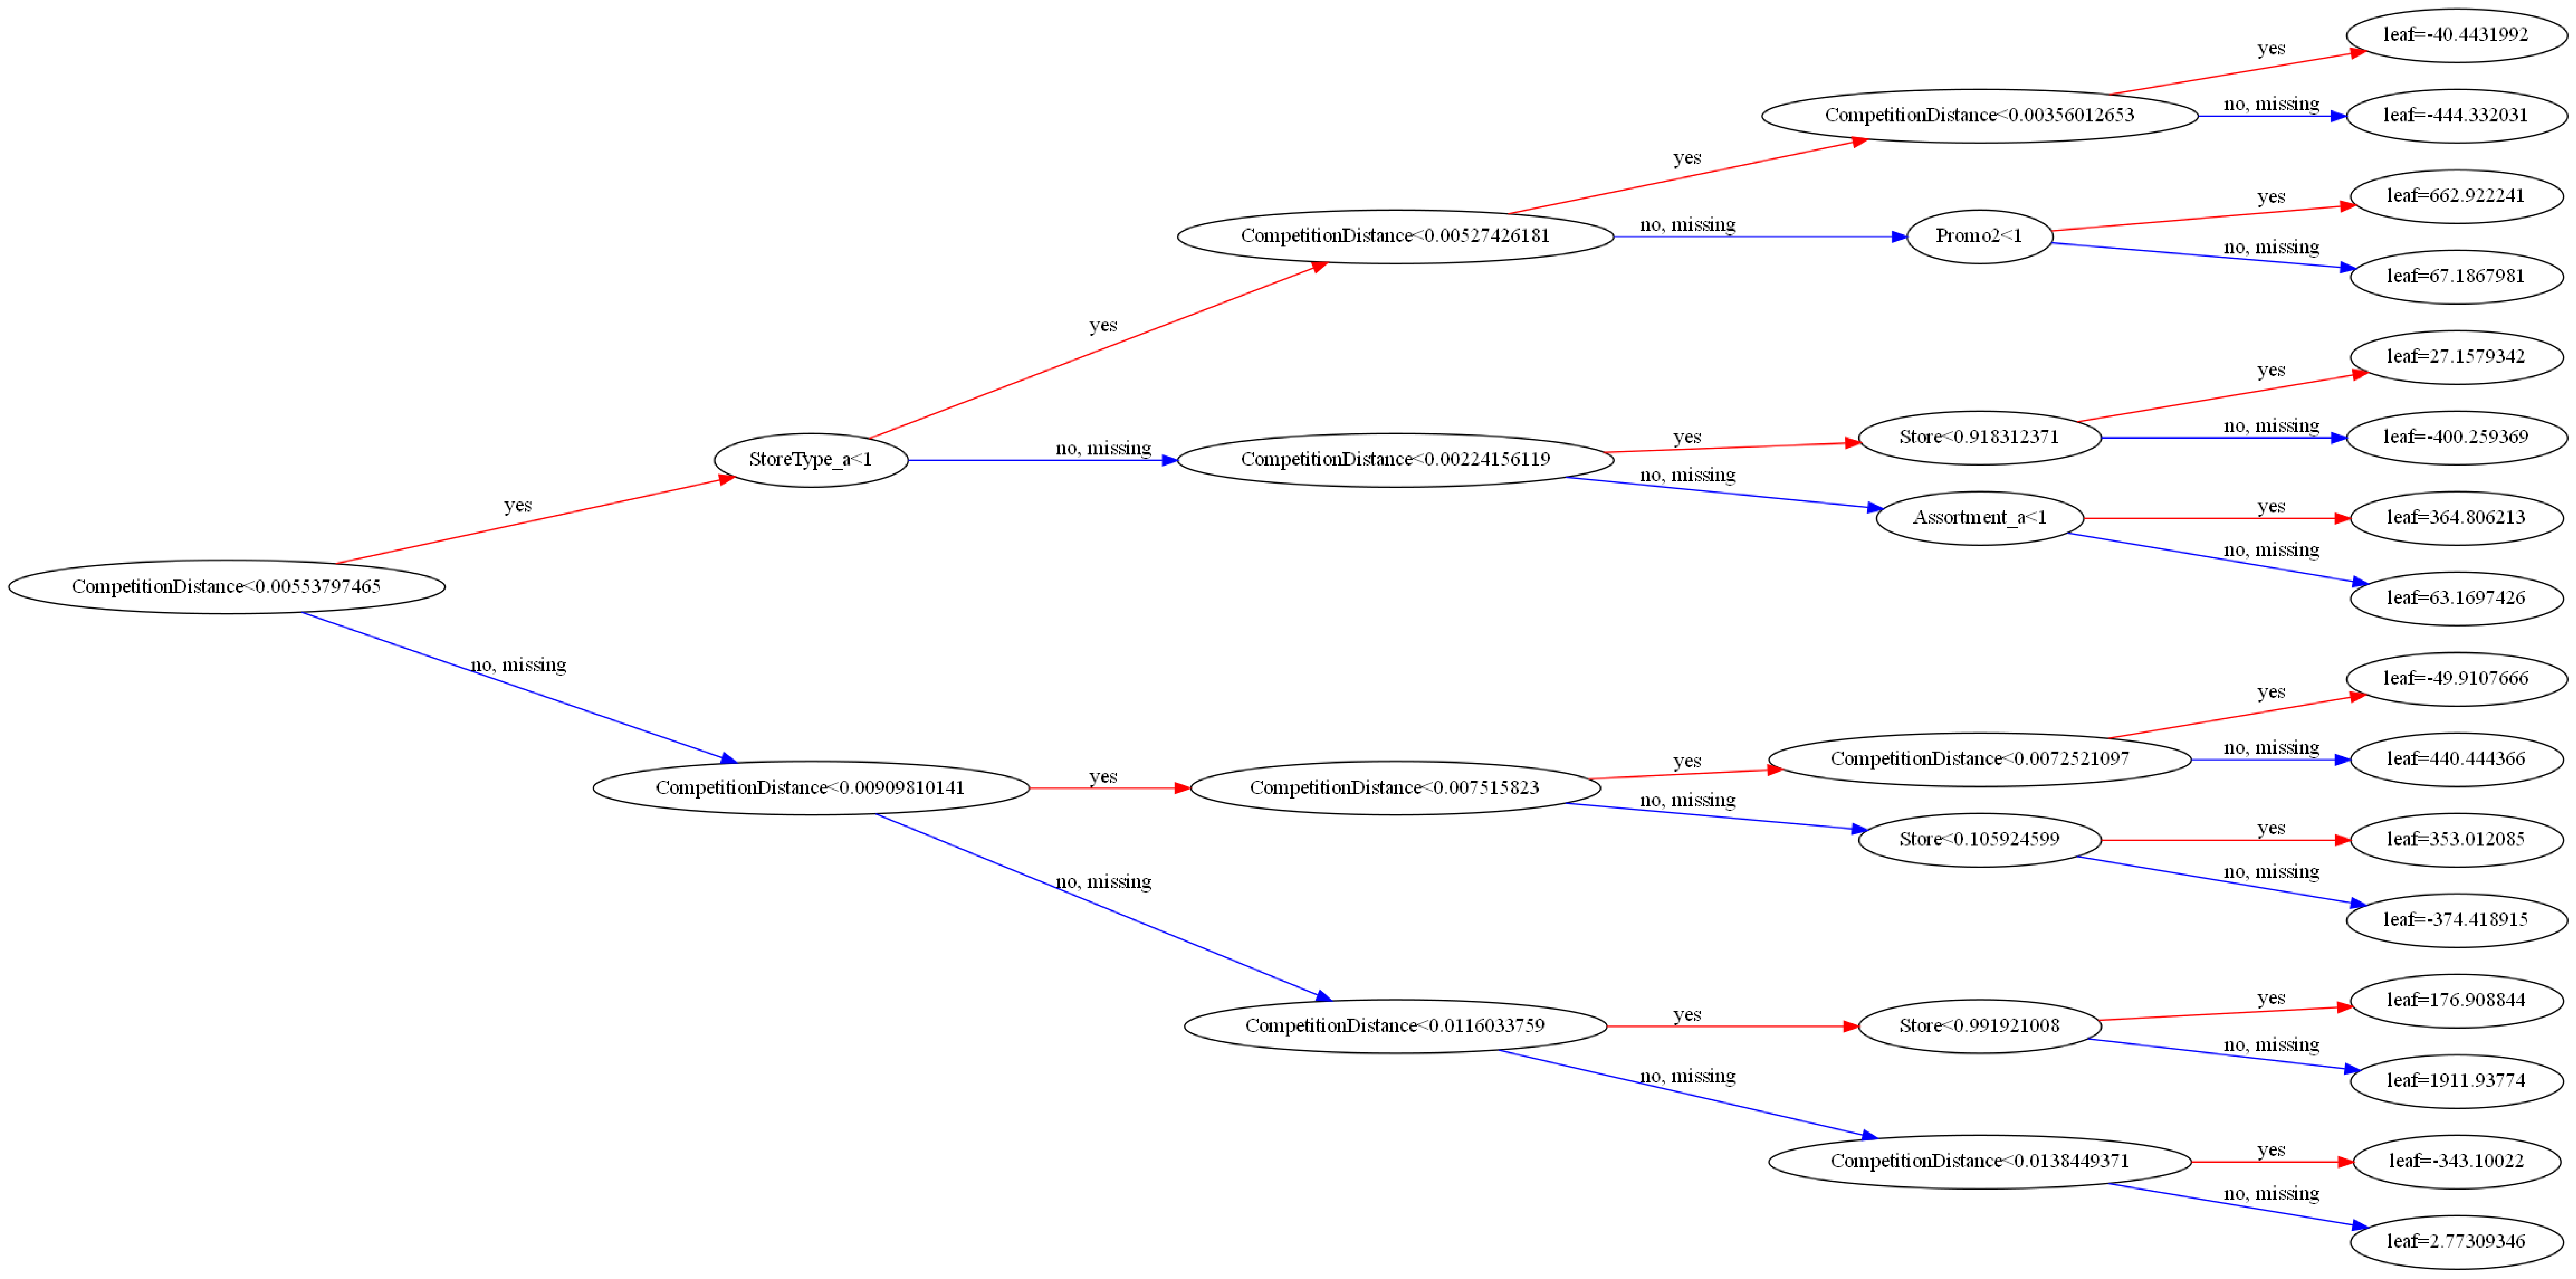

In [60]:
plot_tree(model,rankdir='LR',num_trees=19);

In [61]:
trees=model.get_booster().get_dump()

In [62]:
len(trees)

20

In [63]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.00448312238] yes=15,no=16,missing=16
				15:leaf=223.091629
				16:leaf=-263.189026
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.015822785] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.0117352316] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[Promo2Open<0.53825134] yes=27,no=28,missing=28
				27:leaf=594.708923
				28:leaf=911.24585
			14:[

## Feature Importance 

######  Just like decision trees and random forests,XGBoost also provides a feature importance score for each column in the input

In [64]:
importance_df=pd.DataFrame({
    'feature':x.columns,
    'importance':model.feature_importances_
    
}).sort_values('importance',ascending=False)

In [65]:
importance_df.head(10)

,feature,importance
1,Promo,0.340468
12,DayOfWeek_1,0.107216
24,StoreType_b,0.072145
27,Assortment_a,0.067078
3,CompetitionDistance,0.052287
6,Promo2Open,0.043055
11,WeekOfYear,0.041762
9,Month,0.032855
26,StoreType_d,0.032249
8,Day,0.030975


<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

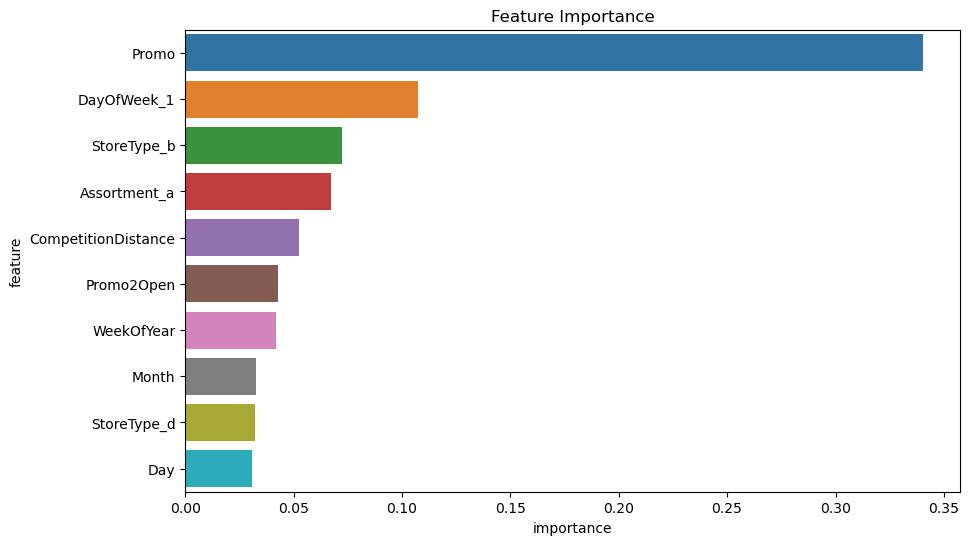

In [66]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10),x='importance',y='feature')

In [67]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "m-zakirhossen99/lesson4" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/m-zakirhossen99/lesson4


'https://jovian.com/m-zakirhossen99/lesson4'

##  K fold cross validation

In [68]:
from sklearn.model_selection import KFold

In [69]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [70]:
kfold = KFold(n_splits=5)


In [71]:
models = []

for train_idxs, val_idxs in kfold.split(x):
    X_train, train_targets = x.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = x.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2394.5850329088153, Validation RMSE: 2473.449183048229


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2413.2188800177273, Validation RMSE: 2451.8140102952057


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2379.5690667402705, Validation RMSE: 2354.1535777010386


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2353.926054272528, Validation RMSE: 2435.568962921588


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2362.543758980047, Validation RMSE: 2426.2962497424137


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [72]:
import numpy as np
def predict_avg(models,inputs):
    return np.mean([model.predict(inputs) for model in models],axis=0)

In [73]:
preds=predict_avg(models,x)

In [74]:
preds

array([8082.331 , 8004.979 , 8497.789 , ..., 7423.2695, 7605.4087,
       9746.525 ], dtype=float32)

In [75]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "m-zakirhossen99/lesson4" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/m-zakirhossen99/lesson4


'https://jovian.com/m-zakirhossen99/lesson4'

# Hyperparameter Tuning And Regularization

#####  Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfititing.

# 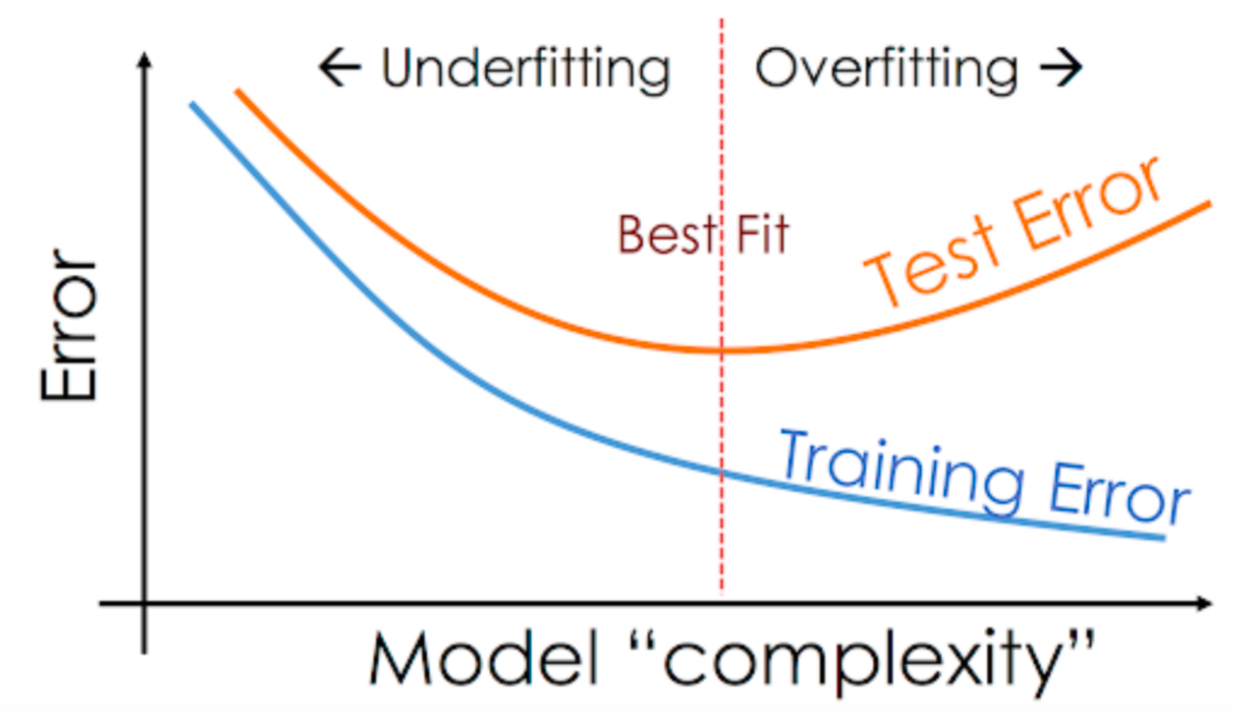

In [76]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [77]:
?XGBRegressor

In [78]:
def test_params_kfold(n_splits,**params):
    train_rmses,val_rmses,model=[],[],[]
    kfold=KFold(n_splits)
    for train_idxs,val_idxs in kfold.split(x):
        x_train,train_targets=x.iloc[train_idxs],targets.iloc[train_idxs]
        x_val,val_targets=x.iloc[val_idxs],targets.iloc[val_idxs]
        model,train_rmse,val_rmse=trian_and_evaluate(x_train,train_targets,x_val,val_targets,**params)
        models.append(model)
        train_rmses.append(trian_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE:{} '.format(np.mean(train_rmse),np.mean(val_rmses)))
    return models

In [79]:
from sklearn.model_selection import train_test_split


In [80]:
x_train,x_val,train_targets,val_targets=train_test_split(x,targets,test_size=0.1)

In [84]:
def test_params(**params):
    model=XGBRegressor(n_jobs=-1,random_state=42,**params)
    model.fit(x_train,train_targets)
    train_rmse=rmse(model.predict(x_train),train_targets)
    val_rmse=rmse(model.predict(x_val),val_targets)
    print('Train RMSE:{}, Validation RMSE:{}'.format(train_rmse,val_rmse))

## n_estimators

In [85]:
test_params(n_estimators=10)

Train RMSE:2321.6983558395673, Validation RMSE:2341.7989896344648


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [86]:
test_params(n_estimators=30)

Train RMSE:1868.6193549031216, Validation RMSE:1888.2590025380903


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [87]:
test_params(n_estimators=100)

Train RMSE:1154.7039316067114, Validation RMSE:1173.8688864424028


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [88]:
test_params(n_estimators=240)

C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE:889.8168340925585, Validation RMSE:913.0353311480643


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## max_depth

In [89]:
test_params(max_depth=2)

Train RMSE:2375.8832151028923, Validation RMSE:2394.074547372549


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [90]:
test_params(max_depth=5)

Train RMSE:1418.2040642236318, Validation RMSE:1433.512073762221


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [91]:
test_params(max_depth=10)

C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE:672.0063366312629, Validation RMSE:777.8713451908743


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## learning_rate

In [93]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE:2783.8318579764314, Validation RMSE:2805.720179136754


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [94]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE:2198.9839893291164, Validation RMSE:2219.1953012873305


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [95]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE:1547.7959292970954, Validation RMSE:1562.7336335424716


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [96]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE:1152.4874834112336, Validation RMSE:1174.2836394706817


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [97]:
test_params(n_estimators=50, learning_rate=0.99)

Train RMSE:1142.5490686450753, Validation RMSE:1160.987417900977


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## booster

######  Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using booster.

In [98]:
test_params(booster='gblinear')

Train RMSE:2723.946707628933, Validation RMSE:2745.8978083574834


C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\mzaki\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [99]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "m-zakirhossen99/lesson4" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/m-zakirhossen99/lesson4


'https://jovian.com/m-zakirhossen99/lesson4'

## Putting it Together and Making Predictions

In [100]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [102]:
%%time
model.fit(x,targets)

CPU times: total: 13min 26s
Wall time: 2min 5s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [103]:
test_preds = model.predict(x_test)

In [104]:
submission_df['Sales']=test_preds

In [105]:
test_df.Open.isna().sum()

11

In [107]:
submission_df['Sales']=submission_df['Sales']*test_df.Open.fillna(1.)

In [108]:
submission_df

,Id,Sales
0,1,12638.781250
1,2,11033.183594
2,3,13534.333008
3,4,9824.784180
4,5,13534.333008
...,...,...
41083,41084,7234.070801
41084,41085,7738.168945
41085,41086,9400.184570
41086,41087,9400.184570


In [114]:
submission_df.to_csv('submisstion.csv',index=None)


In [115]:
from IPython.display import FileLink

In [116]:
FileLink('submisstion.csv')

C:\Users\mzaki\Machinlearning\Roosman\submisstion.csv